In [17]:
from spinorama import load as spload

df = spload.parse_all_speakers()

ModuleNotFoundError: No module named 'spinorama'

In [2]:
nearest = alt.selection(type='single', nearest=True, on='mouseover',fields=['Freq'], empty='none')
# nearest

def display_graph_freq(df, width=900, heigth=500):
    line = alt.Chart(df).mark_line(
            interpolate='basis'
    ).encode(
        alt.X('Freq:Q', scale=alt.Scale(type="log", domain=(20,20000))),
        alt.Y('dB:Q',   scale=alt.Scale(zero=False)),
        alt.Color('Measurements', type='nominal', sort=None)
    ).properties(
        width=width, 
        height=heigth
    )
    selectors = alt.Chart(df).mark_point().encode(x='Freq:Q', opacity=alt.value(0)).add_selection(nearest)
    points = line.mark_point().encode(opacity=alt.condition(nearest, alt.value(1), alt.value(0)))
    text = line.mark_text(align='left', dx=5, dy=-5).encode(text=alt.condition(nearest, 'dB:Q', alt.value(' ')))
    rules = alt.Chart(df).mark_rule(color='gray').encode(x='Freq:Q').transform_filter(nearest)
    return line+selectors+points+rules+text


def display_graph_sidebyside(s1, s2, name):
    d1 = display_graph_freq(s1[name], 450, 450)
    d2 = display_graph_freq(s2[name], 450, 450)
    return alt.hconcat(d1, d2)
    


In [3]:
spinorama=df['Neumann KH 80']['CEA2034']
spinorama = spinorama.loc[spinorama['Measurements'] != 'DI offset']
display_graph_freq(spinorama)

alt.LayerChart(...)

In [4]:
display_graph_freq(df['Neumann KH 80']['Early Reflections'])

alt.LayerChart(...)

In [5]:
onaxis=df['Neumann KH 80']['CEA2034']
onaxis = onaxis.loc[onaxis['Measurements']=='On Axis']
onaxis_graph=display_graph_freq(onaxis)
onaxis_reg = alt.Chart(onaxis).transform_filter(
    'datum.Freq>80 & datum.Freq<18000'
).transform_regression(
    "Freq", "dB"
).mark_line().encode(
    alt.X('Freq:Q'),
    alt.Y('dB:Q'), 
    color=alt.value('red')
)
onaxis_graph+onaxis_reg

alt.LayerChart(...)

In [6]:
inroom = df['Neumann KH 80']['Estimated In-Room Response']
inroom_graph=display_graph_freq(inroom)
inroom_reg=alt.Chart(inroom).transform_filter(
        'datum.Freq>100 & datum.Freq<10000'
).transform_regression(
    "Freq", "dB"
).mark_line().encode(
    alt.X('Freq:Q'),
    alt.Y('dB:Q'), 
    color=alt.value('red')
)
inroom_graph+inroom_reg

alt.LayerChart(...)

In [7]:
display_graph_freq(df['Neumann KH 80']['Horizontal Reflections'])

alt.LayerChart(...)

In [8]:
display_graph_freq(df['Neumann KH 80']['Vertical Reflections'])

alt.LayerChart(...)

In [9]:
splH = df['Selah Audio RC3R']['SPL Horizontal']
filter = {'Measurements': ['On-Axis', '10°', '20°', '30°', '40°', '50°', '60°']}
mask = splH.isin(filter).any(1)
display_graph_freq(splH[mask]) #.interactive()

alt.LayerChart(...)

In [10]:
splV = df['Neumann KH 80']['SPL Vertical']
filter = {'Measurements': ['On-Axis', '10°', '20°', '30°', '40°', '50°', '60°']}
mask = splV.isin(filter).any(1)
display_graph_freq(splV[mask])

alt.LayerChart(...)

In [11]:
import math

def compute_contour(dfu):
    vrange = [0]
    # normalize dB values wrt on axis
    dfm = dfu.copy()
    for c in dfu.columns:
        if c != 'Freq' and c!='On-Axis':
            dfm[c] = dfu[c]-dfu['On-Axis']
            angle = int(c[:-1])
            vrange.append(angle)
    dfm['On-Axis'] = 0
    # print([(math.floor(min*10)/10, math.floor(max*10)/10) for (min,max) in zip(dfm.min(), dfm.max())])
    
    # melt
    dfm = graph_melt(dfm)
    # compute numbers of measurements
    nm = dfm.Measurements.nunique()
    nf =  int(len(dfm.index)/nm)
    # print((nm,nf))
    # index grid on a log scale
    hrange = np.floor(np.logspace(1.3, 4.3, nf))
    # sort data per experiments (not usefull for DataFrame but for 2d array)
    anglemin = np.array(vrange).min()/10
    perm = [int(vrange[i]/10-anglemin) for i in range(0, len(vrange))]
    pvrange = [vrange[perm[i]] for i in range(0,len(vrange))]
    # 3d mesh
    af, am = np.meshgrid(hrange, pvrange)
    # since it is melted generate slices
    az = np.array([
        dfm.dB[nf*perm[i]:nf*(perm[i]+1)] for i in range(0, nm)
    ])
    # smooth values to .1
    #az = np.floor(az*10)/10

    return (af, am, az)

kernel33 = [
    [1,1,1],
    [1,3,1],
    [1,1,1]
]
offset33 = 1
sum33 = np.array(kernel33).sum()
kernel55 = [
    [1,1,1,1,1],
    [1,3,3,3,1],
    [1,3,9,3,1],
    [1,3,3,3,1],
    [1,1,1,1,1]
]
offset55 = 2
sum55 = np.array(kernel55).sum()

kernel = kernel33
offset = offset33
kernel_total = sum33

def smooth(z,i,j,zx,zy):
    s = 0
    if i<offset or (zx-i)<offset or j<offset or (zy-j)<offset:
        s = z[i][j]
    else:
        s = 0
        for ii in range(-offset,offset):
            for jj in range(-offset,offset):
                s += kernel[ii+offset][jj+offset]*z[i+ii][j+jj]
        s /= kernel_total
    return s

def smooth2D(z):
    zx = len(z)
    zy = len(z[0])
    kernel = kernel55
    offset = offset55
    kernel_total = sum55
    return [[smooth(z,i,j,zx,zy) for j in range(0,zy)] for i in range(0,zx)]

def contour_graph(contour):
    af, am, az = contour
    source = pd.DataFrame({'Freq': af.ravel(), 'Angle': am.ravel(), 'dB': az.ravel()})
    return alt.Chart(source).mark_rect(
    ).transform_filter(
        'datum.Freq>400'
    ).encode(
        alt.X('Freq:O'),
        alt.Y('Angle:O'),
        alt.Color('dB:Q',
                  scale=alt.Scale(
                      scheme='category20c'))
    ).properties(
        width=400,
        height=180
    )

def contour_graph_smoothing(speaker):
    contourH = compute_contour(df[speaker]['SPL Horizontal_unmelted'])
    hx, hy, hz = contourH
    contourV = (hx, hy, np.array(smooth2D(hz)))
    #contourV = compute_contour(df[speaker]['SPL Vertical_unmelted'])
    return alt.hconcat(
        contour_graph(contourH), 
        contour_graph(contourV)
    ).configure_range(
    )

def contour_graph_sidebyside(speaker):
    contourH = compute_contour(df[speaker]['SPL Horizontal_unmelted'])
    contourV = compute_contour(df[speaker]['SPL Vertical_unmelted'])
    return alt.hconcat(
        contour_graph(contourH), 
        contour_graph(contourV)
    ).configure_range(
    )

In [12]:
contour_graph_sidebyside('Neumann KH 80')

alt.HConcatChart(...)

In [13]:
contour_graph_sidebyside('Selah Audio RC3R')

alt.HConcatChart(...)

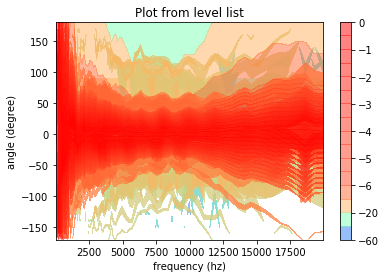

In [14]:
# slighly better looking
import matplotlib.pyplot as plt
x, y, z = compute_contour(df['Neumann KH 80']['SPL Vertical_unmelted'])

plt.figure()
#levels = [-9,-6,-3]
#contour = plt.contour(x, y, z, levels=3, alpha=0.2)
#plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
levels = [-60,-40,-20,-10,-6,-5.5,-5,-4.5,-4,-3.5,-3, -2.5, -2, -1.5, -1, -0.5,0]
contour_filled = plt.contourf(x, y, z, levels, alpha=0.5, cmap='rainbow')
plt.colorbar(contour_filled)
#plt.pcolormesh(x, y, z, shading='gouraud') #, cmap=plt.cm.BuGn_r)
plt.title('Plot from level list')
plt.xlabel('frequency (hz)')
plt.ylabel('angle (degree)')
plt.show()

In [15]:
def near(t,v):
    w = 0
    d = abs(t[0]-v)
    for i in range(len(t)):
        c = abs(t[i]-v)
        if c<d:
            d=c
            w=i
    # print(w, d)
    if v < 0 and t[w] > v:
        return None, 0
    if v > 0 and t[w] < v:
        return None, 0
    # linear interpolation (w-1, t[w-1]) (w,t[w])  ax+b=v x=>(v-b)/a
    if w>1 and t[w] != 0 and d!=0:
        w = w-(t[w]-t[w-1])/t[w]
        d = 0
    return w, d

def compute_isoline(x,y,z,value):
    data = np.array(z)
    # print(len(data))
    isoline = [ near(data[i],-3) for i in range(0,len(data))]
    return isoline
    
x, y, z = compute_contour(df['Neumann KH 80']['SPL Horizontal_unmelted'])
isoline = compute_isoline(x,y,z,-3)
print(isoline)

[(108.80379746835443, 0), (None, 0), (None, 0), (82.82828926409684, 0), (95.0142478462558, 0), (None, 0), (None, 0), (None, 0), (96.9060112919296, 0), (None, 0), (None, 0), (None, 0), (110.83469721767594, 0), (81.79574892062438, 0), (None, 0), (None, 0), (116.890522875817, 0), (84.84816753926701, 0), (154.1175099866844, 0), (None, 0), (None, 0), (88.06119162640901, 0), (180.85066225165562, 0), (None, 0), (None, 0), (86.83433133732535, 0), (None, 0), (90.03910275841164, 0), (189.79113110539845, 0), (88.83817292006525, 0), (None, 0), (90.02450179679843, 0), (None, 0), (89.98435419440746, 0), (None, 0), (None, 0)]
